In [60]:
from sklearn.neighbors import RadiusNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt

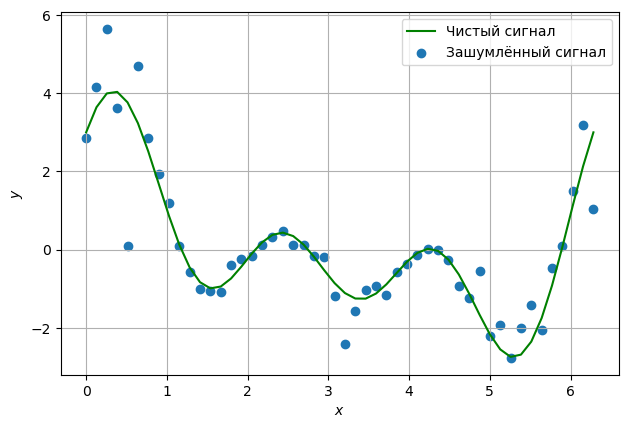

In [105]:
def data_gen(x = np.linspace(0, 2 * np.pi), K=4, noise=0.1):

    y = np.zeros_like(x)
    for k in range(1, K):
        y += np.cos(k * x) + np.sin(k * x)
    
    error = np.random.normal(0, noise, y.shape)
    y = y + error * y
    return x, y

x, y = data_gen(noise=0.4)
x_pure, y_pure =  data_gen(noise=0)

plt.figure(figsize=(7.20, 4.80), dpi=100)
plt.scatter(x, y, label="Зашумлённый сигнал")
plt.plot(x_pure, y_pure, color="g", label="Чистый сигнал")
plt.xlabel("$ x $")
plt.ylabel("$ y $")
plt.legend()
plt.grid(True)

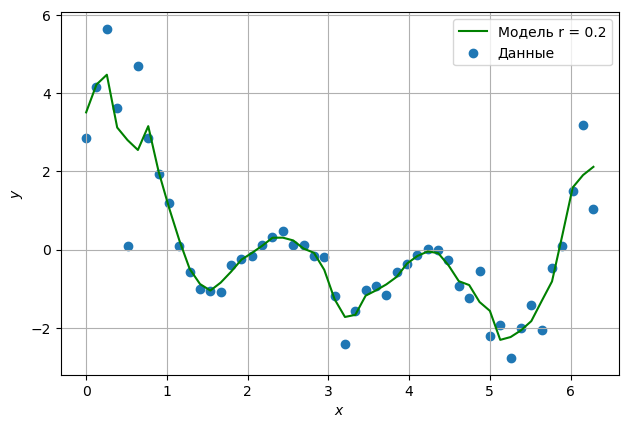

In [106]:
r = 0.2
neighbors = RadiusNeighborsRegressor(radius=r) # вызов библиотечного регрессора

neighbors.fit(x.reshape((-1, 1)), y)

X = np.linspace(x[0], x[-1], 50)
Y = neighbors.predict(X.reshape(-1, 1))

plt.figure(figsize=(7.20, 4.80), dpi=100)
plt.scatter(x, y, label="Данные")
plt.plot(X, Y, color="g", label="Модель r = {:.1f}".format(r))
plt.xlabel("$ x $")
plt.ylabel("$ y $")
plt.legend()
plt.grid(True)

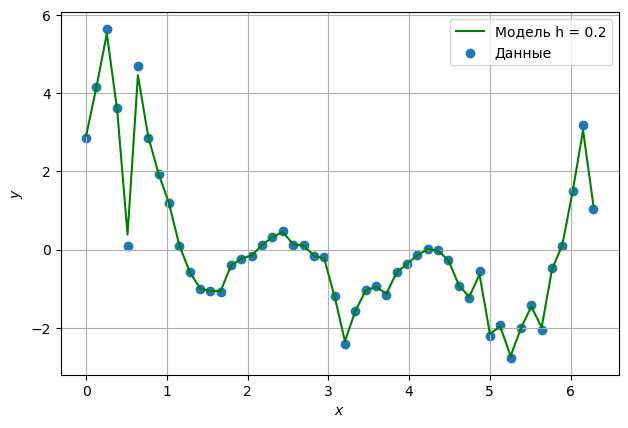

In [107]:
def K(r):
    # Ядро
    return np.exp(-2 * r ** 2)

def dist(x, y):
    # Дистанция
    return np.sqrt((x - y) ** 2)

h = 0.1 # ширина окна

X = np.linspace(x[0], x[-1], 50) # область
Y = np.zeros_like(X)

for i in range(len(X)):
    Y[i] = np.dot(y, K(dist(X[i], x) / h)) / np.sum(K(dist(X[i], x) / h))

plt.figure(figsize=(7.20, 4.80), dpi=100)
plt.scatter(x, y, label="Данные")
plt.plot(X, Y, color="g", label="Модель h = {:.1f}".format(h))
plt.xlabel("$ x $")
plt.ylabel("$ y $")
plt.legend()
plt.grid(True)

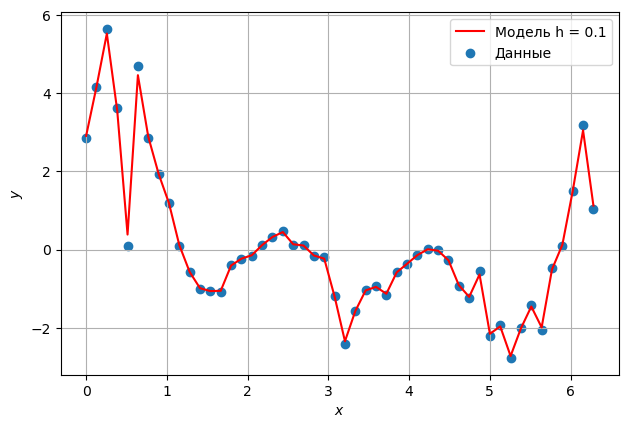

In [109]:
# разные параметры ширины окна

h = [0.1] # ширина окна
colors = ["r", "b", "magenta", "yellow", "red", "black"]

X = np.linspace(x[0], x[-1], 50) # область
Y = np.zeros((len(h), len(X)), dtype=np.float64)

for ih in range(len(h)):
    for i in range(len(X)):
        Y[ih, i] = np.dot(y, K(dist(X[i], x) / h[ih])) / np.sum(K(dist(X[i], x) / h[ih]))

plt.figure(figsize=(7.20, 4.80), dpi=100)
plt.scatter(x, y, label="Данные")
for ih in range(len(h)):
    plt.plot(X, Y[ih, :], color=colors[ih % len(colors)], label="Модель h = {:.1f}".format(h[ih]))
plt.xlabel("$ x $")
plt.ylabel("$ y $")
plt.legend()
plt.grid(True)